### Импорт

In [77]:
import cv2
import csv
import numpy as np
from IPython.display import Image

### Функции для наложения шумов на изображение

In [78]:
# Функция для записи изображений (черно-белая палитра) в формат csv
# для более удобного чтения данных 
def write_in_csv(file_name, data):
    with open(file_name, mode="w") as file:
        file_writer = csv.writer(file, delimiter = ";", lineterminator="\r")
        for irow in data:
            file_writer.writerow(irow)

# Функция поиска максимальной интенсивности изображения 
def find_max_intensity(data):
    pix_min = 0
    current_max = pix_min
    
    for irow in data:
        for ipix in irow:
            if current_max < ipix:
                current_max = ipix
    return current_max

# Функция поиска средней интенсивности пятен на незашумленном изображении
def find_medium_spot_intensity(data):
    pix_min = 0
    summ = 0
    count = 0

    for irow in data:
        for ipix in irow:
            if pix_min < ipix:
                count += 1
                summ += ipix

    return summ / count

# Функция поиска средней интенсивности зашумленных изображений
def find_medium_image_intensity(image_file):
    pix_min = 0
    summ = 0
    count = 0

    gray_image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

    for irow in gray_image:
        for ipix in irow:
            if pix_min < ipix:
                count += 1
                summ += ipix

    return summ / count

# Функция генерации матрицы гауссова шума с соответствующими
# размерами (shape), средним значением (mean) и стандартным отклонением (stddev)
def generate_noise(shape, mean, stddev):
    noise = np.random.normal(mean, stddev, shape).astype(np.uint8)
    #write_in_csv('matrices/noise.csv', noise)
    return noise

# Функция наложения на исходное изображение (data) гауссова шума с соответствующими
# средним значением (mean) и стандартным отклонением (stddev)
def add_noise(data, mean, stddev):
    noise = generate_noise(data.shape, mean, stddev)
    image_with_noise = cv2.add(data, noise)
    #write_in_csv('matrices/image_with_noise.csv', image_with_noise)
    return image_with_noise

# Функция чтения исходного изображения (image_file);
# генерации гауссова шума со средней интенсивностью, 
# соответствующей средней интенсивности пятен на изображении;
# записи зашумленного изображения (noisy_image_file)
def generate_image_with_noise(image_file, noisy_image_file):
    gray_image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    #write_in_csv('matrices/image.csv', image)

    intensity_range = find_max_intensity(gray_image)
    medium_spot_intensity = find_medium_spot_intensity(gray_image)

    mean = medium_spot_intensity
    stddev = medium_spot_intensity // 3

    gray_image_with_noise = add_noise(gray_image, mean, stddev)
    cv2.imwrite(noisy_image_file, gray_image_with_noise)
    return medium_spot_intensity, intensity_range 

### Функции для поиска эллиптических границ

In [79]:
# Функция поиска контуров пятен на заданном изображении (image_file)
# с соответствующими пороговыми значениями (low_threshold, high_threshold)
# для двойной пороговой фильтрации
def find_contours(image_file, low_threshold, high_threshold):
    # Перевод изображения в градации серого 
    image = cv2.imread(image_file)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

    # Размытие изображения для удаления шумов
    # aperture_size -- линейный размер окна медианного фильтра
    # aperture_size должен быть хотя 5, иначе шумы не отфильтруются
    aperture_size = 7
    blur_image = cv2.medianBlur(gray_image, aperture_size)
    #cv2.imwrite('pictures/blur_image.png', blur_image)

    # Выделение границ оператором Кэнни
    canny_image = cv2.Canny(blur_image, low_threshold, high_threshold)
    #cv2.imwrite('pictures/canny_image.png', canny_image)

    # Применение морфологоических преобразований для замыкания границ пятен
    # ancor -- размер ядра морфологических преобразований
    anchor = (5, 5)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, anchor)
    closed_image = cv2.morphologyEx(canny_image, cv2.MORPH_CLOSE, kernel)
    #cv2.imwrite('pictures/closed_image.png', closed_image)

    # Поиск границ пятен
    contours = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    return contours

# Функция поиска границ пятен, аппроксимации этих границ эллипсами 
# с дальнейшшим наложением эллипсов на изоражение
def draw_elliptic_contours(image_file, image_file_with_contours, medium_image_intensity):
    low_threshold   = medium_image_intensity * 1.0 + 2.0
    high_threshold  = medium_image_intensity * 2.0

    if high_threshold > 255:
        high_threshold = 255

    # Поиск границ
    image = cv2.imread(image_file)
    contours = find_contours(image_file, low_threshold, high_threshold)
    
    for contour in contours:
        # сглаживание границ, найденных оператором Кэнни
        contour_perimeter = cv2.arcLength(contour, True)
        epsilon = 0.02 * contour_perimeter
        contour_approximation = cv2.approxPolyDP(contour, epsilon, True)

        if (len(contour_approximation) >= 5):
            # Аппроксимация границ эллипсом
            elliptic_contour_approximation = cv2.fitEllipse(contour_approximation)

            # Добавление эллиптических границ пятен на зашумленное изображение
            green_color     = (0,255,0)
            thickness       = 1
            cv2.ellipse(image, elliptic_contour_approximation, green_color, thickness)
    cv2.imwrite(image_file_with_contours, image)

# Функция поиска границ пятен с дальнейшим их нанесением на изображение
# Первоначальный вариант поиска границ без аппроксимации эллипсом
def draw_contours(image_file, image_file_with_contours):
    image = cv2.imread(image_file)
    contours = find_contours(image_file)
    
    for contour in contours:
        contour_perimeter = cv2.arcLength(contour, True)
        epsilon = 0.02 * contour_perimeter
        contour_approximation = cv2.approxPolyDP(contour, epsilon, True)

        all_contours    = -1
        green_color     = (0,255,0)
        thickness       = 1
        cv2.drawContours(image, [contour_approximation], all_contours, green_color, thickness)
    cv2.imwrite(image_file_with_contours, image)

### Main

Image name:  pictures/image_0.png
Spot intensity range:  38
Medium spot intensity:  17.87
Medium noisy image intensity:  18.23


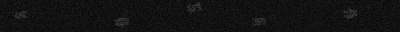

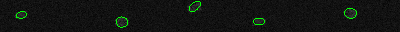

Image name:  pictures/image_1.png
Spot intensity range:  16
Medium spot intensity:  5.96
Medium noisy image intensity:  5.69


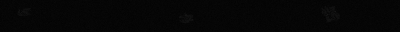

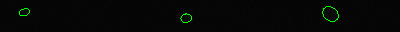

Image name:  pictures/image_2.png
Spot intensity range:  25
Medium spot intensity:  11.60
Medium noisy image intensity:  11.49


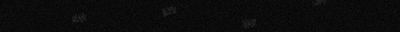

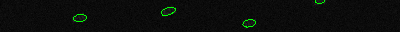

Image name:  pictures/image_3.png
Spot intensity range:  51
Medium spot intensity:  23.96
Medium noisy image intensity:  24.48


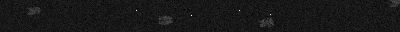

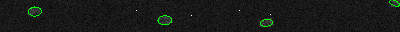

Image name:  pictures/image_4.png
Spot intensity range:  24
Medium spot intensity:  12.12
Medium noisy image intensity:  12.50


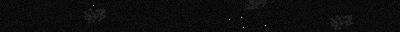

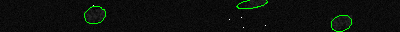

Image name:  pictures/image_5.png
Spot intensity range:  25
Medium spot intensity:  13.75
Medium noisy image intensity:  15.25


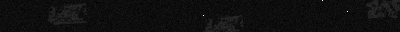

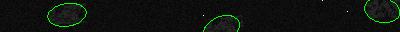

Image name:  pictures/image_6.png
Spot intensity range:  16
Medium spot intensity:  8.19
Medium noisy image intensity:  8.16


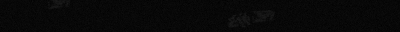

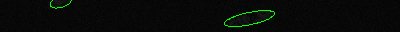

Image name:  pictures/image_7.png
Spot intensity range:  7
Medium spot intensity:  3.66
Medium noisy image intensity:  3.35


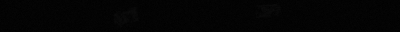

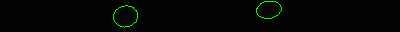

Image name:  pictures/image_8.png
Spot intensity range:  33
Medium spot intensity:  16.15
Medium noisy image intensity:  16.66


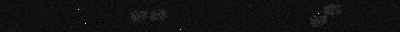

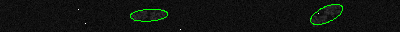

Image name:  pictures/image_9.png
Spot intensity range:  45
Medium spot intensity:  21.40
Medium noisy image intensity:  23.60


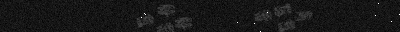

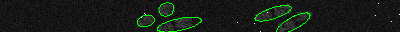

In [80]:
if __name__ == "__main__":

    for i in range(10):
        start_image_name        = 'pictures/image_' + str(i) + '.png'
        noisy_image_name        = 'pictures/noisy_image_' + str(i) + '.png'
        contoured_image_name    = 'results/image_with_elliptic_contours_' + str(i) + '.png'

        print('Image name: ', start_image_name)
        medium_spot_intensity, intensity_range = generate_image_with_noise( start_image_name,
                                                                            noisy_image_name)

        print('Spot intensity range: ', intensity_range)
        print('Medium spot intensity: ', f"{medium_spot_intensity:.2f}")

        medium_image_intensity = find_medium_image_intensity(noisy_image_name)
        print('Medium noisy image intensity: ', f"{medium_image_intensity:.2f}")

        #draw_contours('pictures/noisy_image.png', 'pictures/image_with_contours.png')
        draw_elliptic_contours( noisy_image_name,
                                contoured_image_name,
                                medium_image_intensity)
                                
        display(Image(filename=noisy_image_name, width = 600))
        display(Image(filename=contoured_image_name, width = 600))